In [1]:
from dotenv import load_dotenv
import os
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sqlalchemy import create_engine
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
import matplotlib.pyplot as plt

load_dotenv()

True

In [2]:
db_url = f"postgresql://{os.getenv('DB_USER')}:{os.getenv('DB_PASSWORD')}@{os.getenv('DB_HOST')}:{os.getenv('DB_PORT')}/postgres"
engine = create_engine(db_url)


sql_query = """
    SELECT
        time, olr, speed, speeduncapped, freeflow, jamfactor, traversability, day_of_week, is_peak_hour, time_to_traverse, congestion_level, is_anomaly
    FROM diu.traffic_data WHERE day_of_week IS NOT NULL AND name IS NOT NULL;
"""
traffic_data = pd.read_sql(sql_query, engine)

In [3]:
traffic_data

,time,olr,speed,speeduncapped,freeflow,jamfactor,traversability,day_of_week,is_peak_hour,time_to_traverse,congestion_level,is_anomaly
0,2024-12-19 07:44:21.632000+00:00,CD0BEAA5OAYYECTyQQAJBQQCAuQACgUEAqx8APcBANcACQ...,13.888889,13.888889,16.388890,1.4,open,4,True,551.519996,Low,False
1,2024-12-27 20:00:48.505000+00:00,CCoBEAAmJQYWPiT7GQAJBQQBAk8ACgUEAZ8uABVt/NUACQ...,14.444445,14.444445,14.722222,0.1,open,5,False,245.007683,Low,False
2,2024-12-27 17:00:48.359000+00:00,CCkBEAAlJAYGeiT1zQAJBQQAAdYACgUEAKhjAO2iDaEACQ...,35.277780,35.277780,29.166668,0.0,open,5,True,148.166920,Low,False
3,2024-12-27 17:00:48.359000+00:00,CCgBEAAkIwYTOyUAYQAJBQQBAwAACgQDAQsAAAAACgAJBQ...,6.388889,6.388889,10.555556,3.0,open,5,True,1.721739,Moderate,True
4,2024-12-28 02:20:48.509000+00:00,CCkBEAAlJAYXkiTxsQAJBQQAASEACgUEALcaABT0EnkACQ...,23.333334,23.333334,28.611113,2.7,open,6,False,303.042848,Low,False
...,...,...,...,...,...,...,...,...,...,...,...,...
1244907,2025-01-17 07:18:48.419000+00:00,CCkBEAAlJAYgPST5pAAJBQQBAs0ACgUEAYQZAP0dAJUACQ...,14.166667,14.166667,17.500000,1.8,open,5,True,38.117646,Low,False
1244908,2025-01-17 07:18:48.419000+00:00,CCkBEAAlJAYQbyT+4QAJBQQBAhAACgUEAYRSAAEJAfsACQ...,18.888890,20.555555,18.611110,0.0,open,5,True,31.447057,Low,False
1244909,2025-01-17 07:18:48.419000+00:00,CD0BEAA5OAYJhyT2rAAJBQQCAkMACgUEApJwABRQ9xsACQ...,12.777778,12.777778,15.833334,1.9,open,5,True,589.460859,Low,False
1244910,2025-01-17 07:18:48.419000+00:00,CCkBEAAlJAYIjCT2mwAJBQQBAksACgUEAYJ2AAIbACUACQ...,8.333334,8.333334,14.166667,3.9,open,5,True,45.359996,Moderate,False


In [4]:
tmp_df = traffic_data.copy()
value_counts = tmp_df['olr'].value_counts()
tmp_df = tmp_df[tmp_df['olr'].isin(value_counts[value_counts >= 100].index)]
tmp_df['is_peak_hour'] = tmp_df['is_peak_hour'].astype(int)
tmp_df['is_anomaly'] = tmp_df['is_anomaly'].astype(int)
tmp_df['congestion_level'] = tmp_df['congestion_level'].map({'High': 2, 'Moderate': 1, 'Low': 0})
tmp_df['traversability'] = tmp_df['traversability'].map({'closed': 1, 'open': 0})
tmp_df.loc[tmp_df['traversability'] == 1, 'speed'] = tmp_df.loc[tmp_df['traversability'] == 1, 'speed'].fillna(0)
tmp_df.loc[tmp_df['traversability'] == 1, 'speeduncapped'] = tmp_df.loc[tmp_df['traversability'] == 1, 'speeduncapped'].fillna(0)
tmp_df.loc[tmp_df['traversability'] == 1, 'time_to_traverse'] = tmp_df.loc[tmp_df['traversability'] == 1, 'time_to_traverse'].fillna(0)
tmp_df = tmp_df.dropna()

tmp_df

,time,olr,speed,speeduncapped,freeflow,jamfactor,traversability,day_of_week,is_peak_hour,time_to_traverse,congestion_level,is_anomaly
0,2024-12-19 07:44:21.632000+00:00,CD0BEAA5OAYYECTyQQAJBQQCAuQACgUEAqx8APcBANcACQ...,13.888889,13.888889,16.388890,1.4,0,4,1,551.519996,0,0
1,2024-12-27 20:00:48.505000+00:00,CCoBEAAmJQYWPiT7GQAJBQQBAk8ACgUEAZ8uABVt/NUACQ...,14.444445,14.444445,14.722222,0.1,0,5,0,245.007683,0,0
2,2024-12-27 17:00:48.359000+00:00,CCkBEAAlJAYGeiT1zQAJBQQAAdYACgUEAKhjAO2iDaEACQ...,35.277780,35.277780,29.166668,0.0,0,5,1,148.166920,0,0
3,2024-12-27 17:00:48.359000+00:00,CCgBEAAkIwYTOyUAYQAJBQQBAwAACgQDAQsAAAAACgAJBQ...,6.388889,6.388889,10.555556,3.0,0,5,1,1.721739,1,1
4,2024-12-28 02:20:48.509000+00:00,CCkBEAAlJAYXkiTxsQAJBQQAASEACgUEALcaABT0EnkACQ...,23.333334,23.333334,28.611113,2.7,0,6,0,303.042848,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1244907,2025-01-17 07:18:48.419000+00:00,CCkBEAAlJAYgPST5pAAJBQQBAs0ACgUEAYQZAP0dAJUACQ...,14.166667,14.166667,17.500000,1.8,0,5,1,38.117646,0,0
1244908,2025-01-17 07:18:48.419000+00:00,CCkBEAAlJAYQbyT+4QAJBQQBAhAACgUEAYRSAAEJAfsACQ...,18.888890,20.555555,18.611110,0.0,0,5,1,31.447057,0,0
1244909,2025-01-17 07:18:48.419000+00:00,CD0BEAA5OAYJhyT2rAAJBQQCAkMACgUEApJwABRQ9xsACQ...,12.777778,12.777778,15.833334,1.9,0,5,1,589.460859,0,0
1244910,2025-01-17 07:18:48.419000+00:00,CCkBEAAlJAYIjCT2mwAJBQQBAksACgUEAYJ2AAIbACUACQ...,8.333334,8.333334,14.166667,3.9,0,5,1,45.359996,1,0


In [5]:
time_series_data = tmp_df.pivot_table(
    index="time",
    columns="olr",
    values=["speeduncapped", "freeflow", "jamfactor", "traversability"],
    aggfunc="mean",
).fillna(-1)

time_series_data.columns = ['_'.join(map(str, col)) for col in time_series_data.columns]
time_series_data

,freeflow_CCgBEAAkIwYOoiT9OwAJBQQCAu4ACgQDAiwA/9gAHAAJBQQCAlYAMAAA,freeflow_CCgBEAAkIwYQICT+eQAJBQQBAlcACgQDAUMAAFL/3wAJBQQBAtcAMAAA,freeflow_CCgBEAAkIwYTNyT/1wAJBQQBAi4ACgQDATcAAEgAFwAJBQQBAqsAMAAA,freeflow_CCgBEAAkIwYTOyUAYQAJBQQBAwAACgQDAQsAAAAACgAJBQQBA4AAMAAA,freeflow_CCkBEAAlJAX+WyT8BgAJBQQAAVIACgUEAK9aABbi8QQACQUEAAHSADAAAA==,freeflow_CCkBEAAlJAX/AyT7+gAJBQQBAzIACgUEAoogAAXyAsIACQUEAgKqADAAAA==,freeflow_CCkBEAAlJAXy/yTqawAJBQQBAisACgUEAdA1ACisGCwACQUEAQOcADAAAA==,freeflow_CCkBEAAlJAYByST9QwAJBQQCAhoACgUEAq11ABuA/+sACQUEAgL1ADAAAA==,freeflow_CCkBEAAlJAYF8yT1rwAJBQQBA5wACgUEAdAwANdL59wACQUEAQIqADAAAA==,freeflow_CCkBEAAlJAYF8yT1rwAJBQQBAx4ACgUEAY5+AAfYAxcACQUEAQaXADAAAA==,...,traversability_CCoBEAAmJQYWPiT7GQAJBQQBAk8ACgUEAZ8uABVt/NUACQUEAQLNADAAg20=,traversability_CCoBEAAmJQYjkST9bQAJBQQAAYwACgUEAKxyAPY/7VcACQUEAAEmADBJlCY=,traversability_CD0BEAA5OAYJhyT2rAAJBQQCAkMACgUEApJwABRQ9xsACQUEAgLmAHABC7b+ogAJBQQCAjsACgUEAqdmAAAA,traversability_CD0BEAA5OAYTOyUAZQAJBQQCAwQACgUEAphOAAl0BOsACQUEAgOXAHABBJkKNAAJBQQCAxUACgUEApMNAAAA,traversability_CD0BEAA5OAYTWCT/4gAJBQQCAiYACgUEAql3AAtZCS4ACQUEAgRcAHABG7gCuwAJBQQCAx4ACgUEApsmAAAA,traversability_CD0BEAA5OAYYECTyQQAJBQQCAuQACgUEAqx8APcBANcACQUEAQI2AHAB57UIgQAJBQQCAu4ACgUEAo5SAAAA,traversability_CD0BEAA5OAYZyCUHcQAJBQQCA5cACgUEAo4bAPlw9IkACQUEAQMAAHAB+IP8TgAJBQQCA8EACgUEAp1RAAAA,traversability_CD0BEAA5OAYlZiUFFQAJBQQCA44ACgUEApkiAOQ1/U0ACQUEAQIrAHAB9Pv3kgAJBQQCA50ACgUEAql6AAAA,traversability_CGIBEABeXQX7NyUHiwAJBQQCAykACgQDAmIABGwEYQAJBQQCA6AAcAMAbwA2AAkFBAIDFAAKBQQCvSEAIngJtwAJBQQCA28ACgUEA6ooABOTB0AACQUEAwNHAAoFBAOOUAAAAA==,traversability_CGMBEABfXgYWqiURlgAJBQQCA6AACgUEAoZqAP9n/yMACQUEAgMpAHAD/lz9MQAJBQQCA44ACgUEA7I8AOlz91kACQUEAgPmAAoFBAK7JgDd5PbFAAkFBAIDkAAKBQQCgiIAAAA=
time,,,,,,,,,,,,,,,,,,,,,
2024-12-18 16:12:21.328000+00:00,9.444445,10.555556,5.277778,10.555556,29.166668,12.5,16.666668,11.944445,16.11111,13.888889,...,0,0,0,0,0,0,0,0,0,0
2024-12-18 16:14:21.464000+00:00,9.444445,10.555556,5.277778,10.555556,29.166668,12.5,16.666668,11.944445,16.11111,13.888889,...,0,0,0,0,0,0,0,0,0,0
2024-12-18 16:16:21.532000+00:00,9.444445,10.555556,5.277778,10.555556,29.166668,12.5,16.666668,11.944445,16.11111,13.888889,...,0,0,0,0,0,0,0,0,0,0
2024-12-18 16:18:21.143000+00:00,9.444445,10.555556,5.277778,10.555556,29.166668,12.5,16.666668,11.944445,16.11111,13.888889,...,0,0,0,0,0,0,0,0,0,0
2024-12-18 16:20:21.489000+00:00,9.444445,10.555556,5.277778,10.555556,29.166668,12.5,16.666668,11.944445,16.11111,13.888889,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-17 13:10:48.454000+00:00,9.444445,10.555556,5.277778,10.555556,29.166668,12.5,16.666668,11.944445,16.11111,13.888889,...,0,0,0,0,0,0,0,0,0,0
2025-01-17 13:12:48.539000+00:00,9.444445,10.555556,5.277778,10.555556,29.166668,12.5,16.666668,11.944445,16.11111,13.888889,...,0,0,0,0,0,0,0,0,0,0
2025-01-17 13:14:48.872000+00:00,9.444445,10.555556,5.277778,10.555556,29.166668,12.5,16.666668,11.944445,16.11111,13.888889,...,0,0,0,0,0,0,0,0,0,0


In [6]:
mm_scaler = MinMaxScaler()
time_series_data_normalized = mm_scaler.fit_transform(time_series_data.values.T)
time_series_data_agg = time_series_data.T.groupby(lambda col: col.split('_')[1]).median()

time_series_data_agg_normalized = mm_scaler.fit_transform(time_series_data_agg)

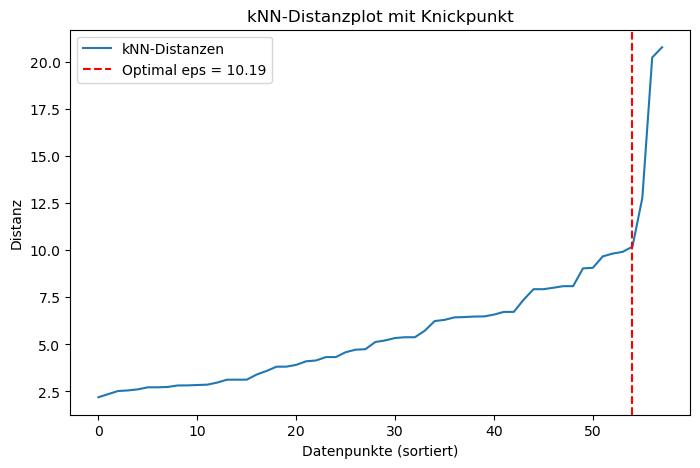

In [7]:
X = time_series_data_agg_normalized

min_samples = 4

nbrs = NearestNeighbors(n_neighbors=min_samples).fit(X)
distances, indices = nbrs.kneighbors(X)

distances = np.sort(distances[:, -1])

knee = KneeLocator(range(len(distances)), distances, curve="convex", direction="increasing")
optimal_eps = distances[knee.knee]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(distances, label="kNN-Distanzen")
plt.axvline(x=knee.knee, color="r", linestyle="--", label=f"Optimal eps = {optimal_eps:.2f}")
plt.title("kNN-Distanzplot mit Knickpunkt")
plt.xlabel("Datenpunkte (sortiert)")
plt.ylabel("Distanz")
plt.legend()
plt.show()

In [8]:
X = time_series_data_agg_normalized

# Verschiedene Werte für min_samples testen
min_samples_range = range(2, 15)  # Werte von 3 bis 10 testen

results = []
for min_samples in min_samples_range:
    nbrs = NearestNeighbors(n_neighbors=min_samples).fit(X)
    distances, indices = nbrs.kneighbors(X)
    
    distances = np.sort(distances[:, -1])
    
    knee = KneeLocator(range(len(distances)), distances, curve="convex", direction="increasing")
    optimal_eps = distances[knee.knee]
    
    dbscan = DBSCAN(eps=optimal_eps, min_samples=min_samples).fit(X)
    labels = dbscan.labels_

    # Clusterqualität nur bewerten, wenn es mehr als 1 Cluster gibt
    if len(set(labels)) > 1:
        silhouette_avg = silhouette_score(X, labels)
        results.append((min_samples, silhouette_avg))

results

[(2, 0.251619308645432),
 (3, 0.37397219794007835),
 (4, 0.37802419161461953),
 (5, 0.4909777061446611),
 (6, 0.4909777061446611),
 (7, 0.3528538323255944)]

In [9]:
min_samples = 4

nbrs = NearestNeighbors(n_neighbors=min_samples).fit(X)
distances, indices = nbrs.kneighbors(X)

distances = np.sort(distances[:, -1])

knee = KneeLocator(range(len(distances)), distances, curve="convex", direction="increasing")
optimal_eps = distances[knee.knee]

dbscan = DBSCAN(eps=optimal_eps, min_samples=min_samples, metric="euclidean")
labels_dbscan = dbscan.fit_predict(time_series_data_agg_normalized)

sil_score = silhouette_score(time_series_data_agg_normalized, labels_dbscan)
sil_score

0.37802419161461953

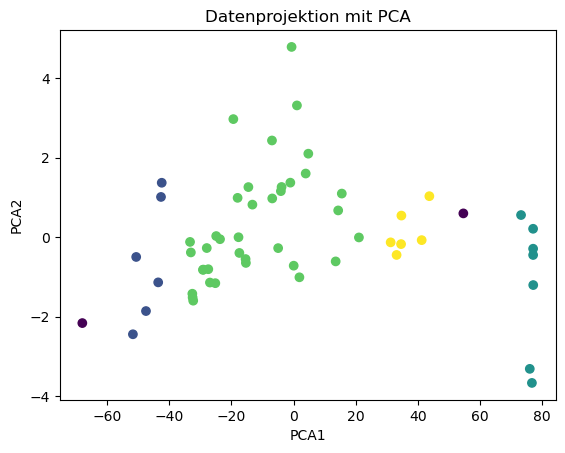

In [10]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(time_series_data_agg_normalized)

plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels_dbscan, cmap="viridis")
plt.title("Datenprojektion mit PCA")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.show()

In [11]:
index_values = time_series_data.T.index
split_values = [value.split('_')[1] for value in index_values]
unique_values = list(set(split_values))

new_df = pd.DataFrame({
    'olr': unique_values,
    'x': reduced_data[:, 0], 
    'y': reduced_data[:, 1],
    'cluster': labels_dbscan,
    'method': 'DBSCAN'
})
new_df

,olr,x,y,cluster,method
0,CCkBEAAlJAYgkiT4pwAJBQQAAYkACgUEALBfAOua8JsACQ...,-43.543821,-1.136427,0,DBSCAN
1,CCkBEAAlJAYXkiTxsQAJBQQAASEACgUEALcaABT0EnkACQ...,-42.406133,1.368477,0,DBSCAN
2,CCkBEAAlJAYpMiT13QAJBQQBAtUACgUEAaAgAOzJCBsACQ...,-67.949102,-2.160074,-1,DBSCAN
3,CCoBEAAmJQYWPiT7GQAJBQQBAk8ACgUEAZ8uABVt/NUACQ...,-42.641059,1.011853,0,DBSCAN
4,CCkBEAAlJAYF8yT1rwAJBQQBAx4ACgUEAY5+AAfYAxcACQ...,77.101254,-1.204038,1,DBSCAN
5,CCkBEAAlJAYOeyT83AAJBQQBApwACgUEAZImAPhI+XMACQ...,-24.881779,0.028031,2,DBSCAN
6,CGMBEABfXgYWqiURlgAJBQQCA6AACgUEAoZqAP9n/yMACQ...,-1.034195,1.371098,2,DBSCAN
7,CCkBEAAlJAYphST1mAAJBQQCA3AACgUEArotAOxh6hUACQ...,-26.897624,-1.140947,2,DBSCAN
8,CCkBEAAlJAYP8ST9cAAJBQQBAkcACgUEAZY0AA2F+voACQ...,-4.077420,1.158063,2,DBSCAN
9,CCkBEAAlJAYWFiT7JwAJBQQBAs0ACgUEAZYeAPLSBR4ACQ...,-17.996566,0.989069,2,DBSCAN


In [12]:
os.environ["OMP_NUM_THREADS"] = "2"
n_clusters = 4

kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
labels_kmeans = kmeans.fit_predict(time_series_data_agg_normalized)

sil_score = silhouette_score(time_series_data_agg_normalized, labels_kmeans)
sil_score

C:\Users\dgojn\anaconda3\envs\Datenanalyse-in-Unternehmen\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


0.5513745793811711

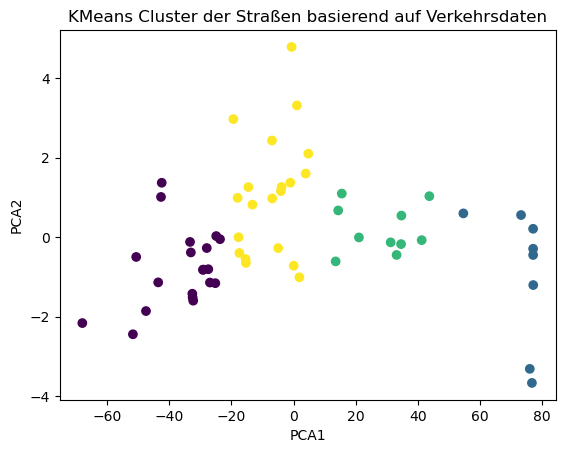

In [13]:
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels_kmeans, cmap="viridis")
plt.title("KMeans Cluster der Straßen basierend auf Verkehrsdaten")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.show()

In [14]:
new_df_2 = pd.DataFrame({
    'olr': unique_values,
    'x': reduced_data[:, 0],
    'y': reduced_data[:, 1],
    'cluster': labels_kmeans,
    'method': 'KMEANS'
})
new_df_2

,olr,x,y,cluster,method
0,CCkBEAAlJAYgkiT4pwAJBQQAAYkACgUEALBfAOua8JsACQ...,-43.543821,-1.136427,0,KMEANS
1,CCkBEAAlJAYXkiTxsQAJBQQAASEACgUEALcaABT0EnkACQ...,-42.406133,1.368477,0,KMEANS
2,CCkBEAAlJAYpMiT13QAJBQQBAtUACgUEAaAgAOzJCBsACQ...,-67.949102,-2.160074,0,KMEANS
3,CCoBEAAmJQYWPiT7GQAJBQQBAk8ACgUEAZ8uABVt/NUACQ...,-42.641059,1.011853,0,KMEANS
4,CCkBEAAlJAYF8yT1rwAJBQQBAx4ACgUEAY5+AAfYAxcACQ...,77.101254,-1.204038,1,KMEANS
5,CCkBEAAlJAYOeyT83AAJBQQBApwACgUEAZImAPhI+XMACQ...,-24.881779,0.028031,0,KMEANS
6,CGMBEABfXgYWqiURlgAJBQQCA6AACgUEAoZqAP9n/yMACQ...,-1.034195,1.371098,3,KMEANS
7,CCkBEAAlJAYphST1mAAJBQQCA3AACgUEArotAOxh6hUACQ...,-26.897624,-1.140947,0,KMEANS
8,CCkBEAAlJAYP8ST9cAAJBQQBAkcACgUEAZY0AA2F+voACQ...,-4.077420,1.158063,3,KMEANS
9,CCkBEAAlJAYWFiT7JwAJBQQBAs0ACgUEAZYeAPLSBR4ACQ...,-17.996566,0.989069,3,KMEANS


In [15]:
comparison = new_df != new_df_2
comparison

,olr,x,y,cluster,method
0,False,False,False,False,True
1,False,False,False,False,True
2,False,False,False,True,True
3,False,False,False,False,True
4,False,False,False,False,True
5,False,False,False,True,True
6,False,False,False,True,True
7,False,False,False,True,True
8,False,False,False,True,True
9,False,False,False,True,True


In [16]:
table_name = "traffic_patters_cluster"
new_df.to_sql(table_name, con=engine, if_exists='append', index=False, schema='diu')
new_df_2.to_sql(table_name, con=engine, if_exists='append', index=False, schema='diu')

58